# Diabetes prediction: gradient boosting

## Notebook set-up

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import randint, uniform, loguniform
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

import configuration as config
import functions as funcs

## 1. Data loading

### 1.1. Load data from disk

Load the pre-processed data from the decision tree notebook:

In [2]:
with open(config.DATA_FILE, 'rb') as input_file:
    dataset = pickle.load(input_file)

training_df = dataset['training']
testing_df = dataset['testing']

### 1.2. Inspect

In [3]:
training_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
184,4,141.0,74.0,20.852201,38.168839,27.6,0.244,40,0
527,3,116.0,74.0,15.000000,105.000000,26.3,0.107,24,0
550,1,116.0,70.0,28.000000,140.843681,27.4,0.204,21,0
473,7,136.0,90.0,26.706840,238.649701,29.9,0.210,50,0
507,1,130.0,60.0,23.000000,170.000000,28.6,0.692,21,0


## 2. Model training

### 2.1. Previous scores

In [4]:
# Load cross validation scores from previous models
with open(config.CROSS_VAL_SCORES_FILE, 'rb') as input_file:
    cross_val_scores = pickle.load(input_file)

### 2.2. Gradient boosting model

In [5]:
naive_model = GradientBoostingClassifier()
naive_model.fit(training_df.drop('Outcome', axis=1), training_df['Outcome'])

accuracy = accuracy_score(naive_model.predict(training_df.drop('Outcome', axis=1)), training_df['Outcome'])*100
print(f'Training accuracy of gradient boosting model: {accuracy:.1f}%')

Training accuracy of gradient boosting model: 97.7%


In [6]:
scores = cross_val_score(
    naive_model,
    training_df.drop('Outcome', axis=1),
    training_df['Outcome'],
    cv=7,
    n_jobs=-1
)

cross_val_scores['Model'].extend(['Gradient boosting']*len(scores))
cross_val_scores['Score'].extend(scores*100)

print(f'Cross-validation accuracy: {np.mean(scores)*100:.1f} +/- {np.std(scores)*100:.1f}%')

Cross-validation accuracy: 77.4 +/- 4.6%


## 3. Hyperparameter optimization

### 3.1. Hyperparameter search

In [7]:
%%time

hyperparameters = {
    'loss': ['log_loss', 'exponential'],
    'learning_rate': loguniform(10**-5, 1.0),
    'n_estimators': randint(2, 200),
    'subsample': uniform(loc=0.1, scale=0.9),
    'criterion':['friedman_mse', 'squared_error'],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'min_weight_fraction_leaf':loguniform(10**-5, 0.5),
    'max_depth':randint(1, 20),
    'min_impurity_decrease':loguniform(10**-5, 1.0),
    'init': ['zero', None],
    'max_features':uniform(loc=0.1, scale=0.9),
    'max_leaf_nodes':randint(2, 1000),
    'ccp_alpha':loguniform(10**-5, 10.0)
}

search = RandomizedSearchCV(
    GradientBoostingClassifier(),
    hyperparameters,
    return_train_score=True,
    cv=config.CROSS_VAL_FOLDS,
    n_jobs=-1,
    n_iter=config.RANDOM_SEARCH_ITERATIONS,
)

search_results = search.fit(training_df.drop('Outcome', axis=1), training_df['Outcome'])
best_model = search_results.best_estimator_
winning_hyperparameters = search_results.best_params_

print('Best hyperparameters:\n')

for key, value in search_results.best_params_.items():
    print(f' {key}: {value}')

print()

print(f'Run time ({os.cpu_count()} CPUs):\n')


Best hyperparameters:

 ccp_alpha: 2.0799057442413715e-05
 criterion: friedman_mse
 init: zero
 learning_rate: 0.03203040846644316
 loss: exponential
 max_depth: 19
 max_features: 0.7554317802337438
 max_leaf_nodes: 475
 min_impurity_decrease: 0.04993086749655062
 min_samples_leaf: 14
 min_samples_split: 14
 min_weight_fraction_leaf: 0.05282005695168268
 n_estimators: 71
 subsample: 0.6499911960914275

Run time (20 CPUs):

CPU times: user 20.3 s, sys: 587 ms, total: 20.9 s
Wall time: 2min 3s


### 3.2. Hyperparameter optimization results

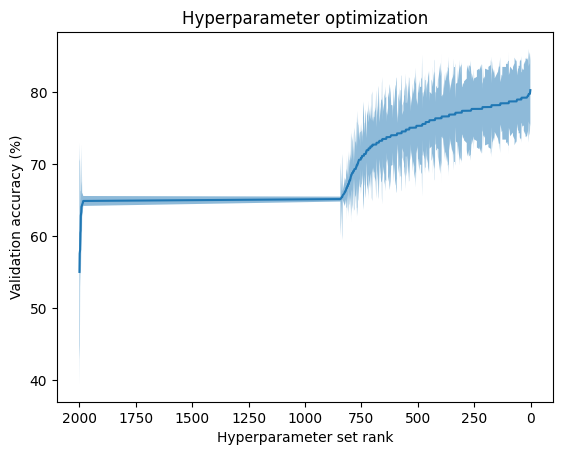

In [8]:
funcs.plot_cross_validation(search_results)

### 3.3. Cross-validation of optimized model

In [9]:
scores = cross_val_score(
    best_model,
    training_df.drop('Outcome', axis=1),
    training_df['Outcome'],
    n_jobs=-1
)

cross_val_scores['Model'].extend(['Optimized gradient boosting']*len(scores))
cross_val_scores['Score'].extend(scores*100)

print(f'Cross-validation accuracy: {np.mean(scores)*100:.1f} +/- {np.std(scores)*100:.1f}%')

Cross-validation accuracy: 79.2 +/- 5.3%


## 4. Evaluation

### 4.1. Model comparison

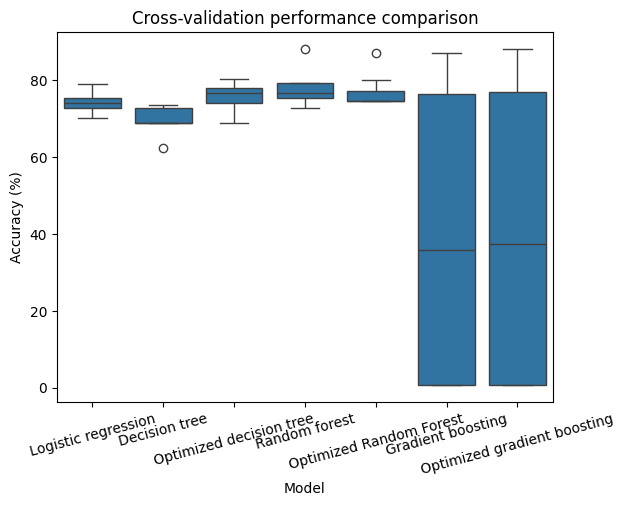

In [10]:
sns.boxplot(pd.DataFrame.from_dict(cross_val_scores), x='Model', y='Score')
plt.title('Cross-validation performance comparison')
plt.ylabel('Accuracy (%)')
plt.xticks(rotation=15)
plt.show()

### 5.3. Test set performance

#### 5.3.1. Load the previous models models

In [11]:
models = {}

models['Logistic regression'] = LogisticRegression(class_weight=config.CLASS_WEIGHT, max_iter=5000).fit(training_df.drop('Outcome', axis=1), training_df['Outcome'])

with open(config.DECISION_TREE_MODEL, 'rb') as input_file:
    models['Decision tree'] = pickle.load(input_file)

with open(config.RANDOM_FOREST_MODEL, 'rb') as input_file:
    models['Random forest'] = pickle.load(input_file)

#### 5.3.2. Gradient boosting model

In [12]:
# Retrain the best model on the full training set
best_model = GradientBoostingClassifier(**winning_hyperparameters)
result = best_model.fit(training_df.drop('Outcome', axis=1), training_df['Outcome'])
models['Gradient boosting'] = best_model

#### 5.3.2. Evaluate each model

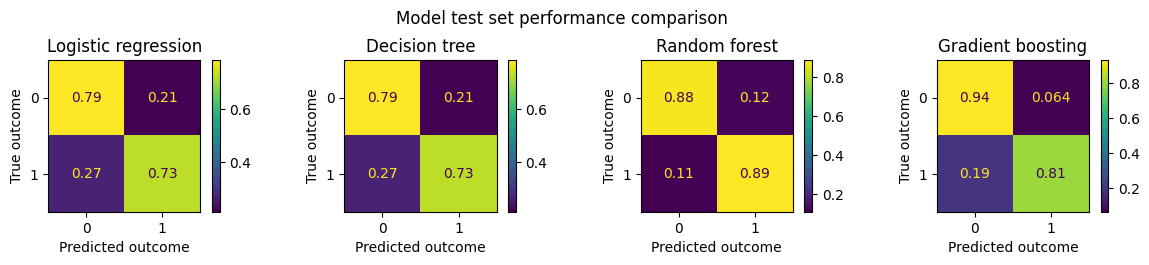

In [13]:
fig, axs = plt.subplots(1,4, figsize=(12,2.5))
axs = axs.flatten()

fig.suptitle(f'Model test set performance comparison')

for i, (model_name, model) in enumerate(models.items()):

    testing_predictions = model.predict(testing_df.drop('Outcome', axis=1))
    accuracy = accuracy_score(testing_predictions, testing_df['Outcome'])*100

    # Plot the confusion matrix
    cm = confusion_matrix(testing_df['Outcome'], testing_predictions, normalize='true')
    cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    _ = cm_disp.plot(ax=axs[i])

    axs[i].set_title(model_name)
    axs[i].set_xlabel('Predicted outcome')
    axs[i].set_ylabel('True outcome')

fig.tight_layout()

## 6. Save

### 6.1. Cross-validation scores

In [14]:
with open(config.CROSS_VAL_SCORES_FILE, 'wb') as output_file:
    pickle.dump(cross_val_scores, output_file)

In [15]:
with open(config.GRADIENT_BOOSTING_HYPERPARAMETERS, 'wb') as output_file:
    pickle.dump(winning_hyperparameters, output_file)

### 6.2. Model

In [16]:
# Save the winning hyperparameters
with open(config.GRADIENT_BOOSTING_HYPERPARAMETERS, 'wb') as output_file:
    pickle.dump(winning_hyperparameters, output_file)

# Save the best model
with open(config.GRADIENT_BOOSTING_MODEL, 'wb') as output_file:
    pickle.dump(model, output_file)